In [2]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [3]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import *
from pyspark.sql.types import *

MAX_MEMORY = '16G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'region25.csv'
df = spark.read.option("header", "true").csv(filename_data, mode="DROPMALFORMED")
df = df.withColumn("year",df.year.cast(DoubleType())) \
    .withColumn("mileage",df.mileage.cast(DoubleType())) \
    .withColumn("power",df.power.cast(DoubleType())) \
    .withColumn("price",df.price.cast(IntegerType())) \
    .drop("vehicleConfiguration", "engineName", "engineDisplacement", "date", "link", "description", "parse_date")

print('Data overview')
df.printSchema()

total_cars_count = df.count()
total_cars_count

Data overview
root
 |-- brand: string (nullable = true)
 |-- name: string (nullable = true)
 |-- bodyType: string (nullable = true)
 |-- color: string (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- year: double (nullable = true)
 |-- mileage: double (nullable = true)
 |-- transmission: string (nullable = true)
 |-- power: double (nullable = true)
 |-- price: integer (nullable = true)
 |-- location: string (nullable = true)



1513200

# Пропущенные значения

In [4]:
string_columns = ['brand', 'color', 'fuelType', 'transmission', 'location', 'name', 'bodyType']
numeric_columns = ['year','mileage', 'power', 'price']

def view_missing_values_in_columns(string_columns, numeric_columns):
    missing_values = {}
    for index, column in enumerate(df.columns):
        if column in string_columns:
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        else: 
            missing_count = df.where(col(column).isin([0,None,np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    
    return missing_values

pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,brand,name,bodyType,color,fuelType,year,mileage,transmission,power,price,location
0,0,0,0,109734,3560,410974,14480,3065,20887,0,0


# Устранение пропущенных значений и вывод количества пропущенных значений после процедуры

In [5]:
df = df.withColumn('color', 
                   when(col('color').isin([0,None,np.nan]) | col('color').isNull(),
                        None).otherwise(col('color')))
df = df.dropna(subset=['color'])
df = df.withColumn('fuelType', 
                   when(col('fuelType').isin([0,None,np.nan]) | col('fuelType').isNull(),
                        None).otherwise(col('fuelType')))
df = df.dropna(subset=['fuelType'])
df = df.withColumn('year', 
                   when(col('year').isin([0,None,np.nan]) | col('year').isNull(),
                        None).otherwise(col('year')))
df = df.dropna(subset=['year'])
df = df.withColumn('mileage', 
                   when(col('mileage').isin([0,None,np.nan]) | col('mileage').isNull(),
                        None).otherwise(col('mileage')))
df = df.dropna(subset=['mileage'])
df = df.withColumn('transmission', 
                   when(col('transmission').isin([0,None,np.nan]) | col('transmission').isNull(),
                        None).otherwise(col('transmission')))
df = df.dropna(subset=['transmission'])
df = df.withColumn('power', 
                   when(col('power').isin([0,None,np.nan]) | col('power').isNull(),
                        None).otherwise(col('power')))
df = df.dropna(subset=['power'])
pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,brand,name,bodyType,color,fuelType,year,mileage,transmission,power,price,location
0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
'Data frame describe (numeric columns only):'
df.select(df.year, df.mileage, df.price, df.power).describe().toPandas()

'Data frame describe (numeric columns only):'

,summary,year,mileage,price,power
0,count,1002350,1002350,1002350,1002350
1,mean,2010.0043437920885,129293.35960492842,1480836.848853195,150.3699645832294
2,stddev,7.646783070403334,82738.80382814788,1684101.4983202617,73.25043732119359
3,min,1943.0,1000.0,20000,30.0
4,max,2022.0,1000000.0,41500000,650.0


#  Используем межквартильный диапозон, чтобы устранить выбросы #

In [7]:
for column in ['mileage', 'price', 'power']:

    # Q1 : First Quartile ., Q3 : Third Quartile
    Q1 = df.approxQuantile(column,[0.25],relativeError=0)
    Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
    # IQR : Inter Quantile Range
    # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
    # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
    IQR = Q3[0] - Q1[0]
        
    #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
    less_Q1 =  Q1[0] - 1.5*IQR
    more_Q3 =  Q3[0] + 1.5*IQR
           
    df = df.filter((df[column] < more_Q3) & (df[column] > less_Q1))    

df.select(df.year, df.mileage, df.price, df.power).describe().toPandas()

,summary,year,mileage,price,power
0,count,868701,868701,868701,868701
1,mean,2009.715552301655,129804.41947229253,1129332.933367177,131.00099919304802
2,stddev,7.593433436199661,74576.50310161016,839304.0502951195,44.431223110801206
3,min,1943.0,1000.0,20000,30.0
4,max,2022.0,346000.0,3715000,258.0


In [8]:
df.toPandas().to_csv('mycsv.csv')

# Вывод 10 популярных бредов автомобилей

Top 10 cars brands:


/tmp/ipykernel_41/2468827938.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(highest_cars_brands_df['brand'],


,brand,count,percentage
0,Toyota,427387,28.243920
1,Honda,134621,8.896445
2,Nissan,102972,6.804917
3,Mitsubishi,33706,2.227465
4,Subaru,32811,2.168319
5,Suzuki,29725,1.964380
6,Lexus,23976,1.584457
7,Mazda,23941,1.582144
8,Daihatsu,14796,0.977795
9,Mercedes-Benz,7451,0.492400


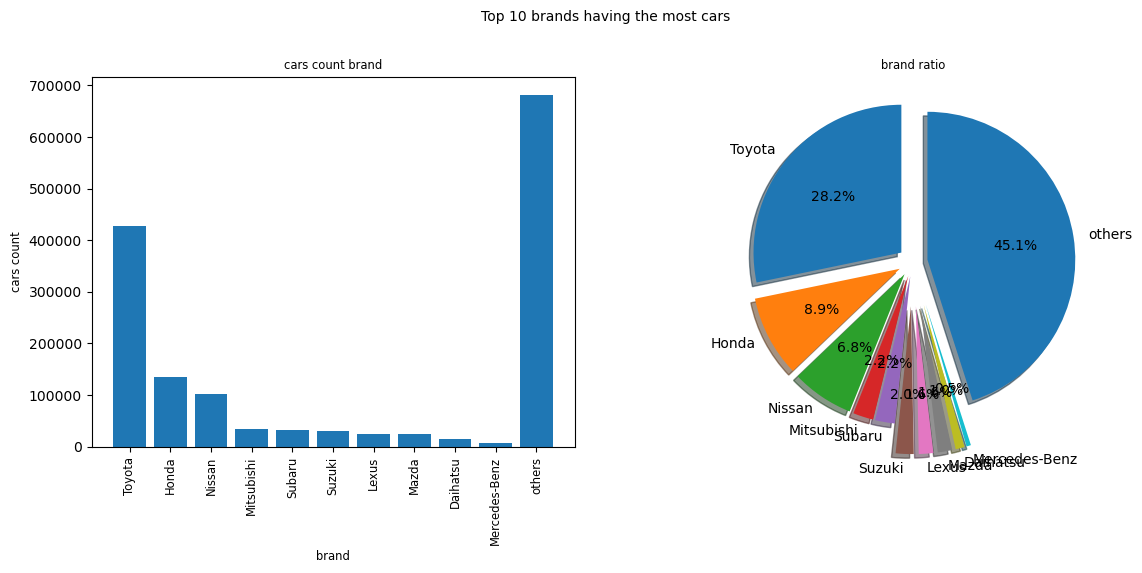

In [9]:
highest_cars_brands_df = df.select(df.brand) \
    .groupBy(df.brand) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10) \
    .toPandas()


highest_cars_brands_df['percentage'] = highest_cars_brands_df['count'] \
    / total_cars_count * 100

others = {
    'brand': 'others', 
    'count': total_cars_count - np.sum(highest_cars_brands_df['count']), 
    'percentage': 100 - np.sum(highest_cars_brands_df['percentage'])
}

highest_cars_brands_df = pd.concat([highest_cars_brands_df,pd.DataFrame.from_dict([others])])


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_cars_brands_df['brand'], 
                     height=highest_cars_brands_df['count'])
title0 =  axs[0].set_title('cars count brand', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('brand', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('cars count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_cars_brands_df['brand'],
                                       rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.3,0.3,0.3,0.3,0.3,0.1)
title1 = axs[1].set_title('brand ratio', fontsize = 'small')
plot1 = axs[1].pie(
    x=highest_cars_brands_df['percentage'],
    labels=highest_cars_brands_df['brand'], 
    autopct='%1.1f%%', 
    shadow=True, 
    explode=explode, 
    startangle=90, 
    radius=1
)

print('Top 10 cars brands:')
highest_cars_brands_df


text = fig.text(0.5, 1.02, 'Top 10 brands having the most cars', ha='center', va='top', transform=fig.transFigure)

# Диаграмма распределения брендов по использованию типа топлива

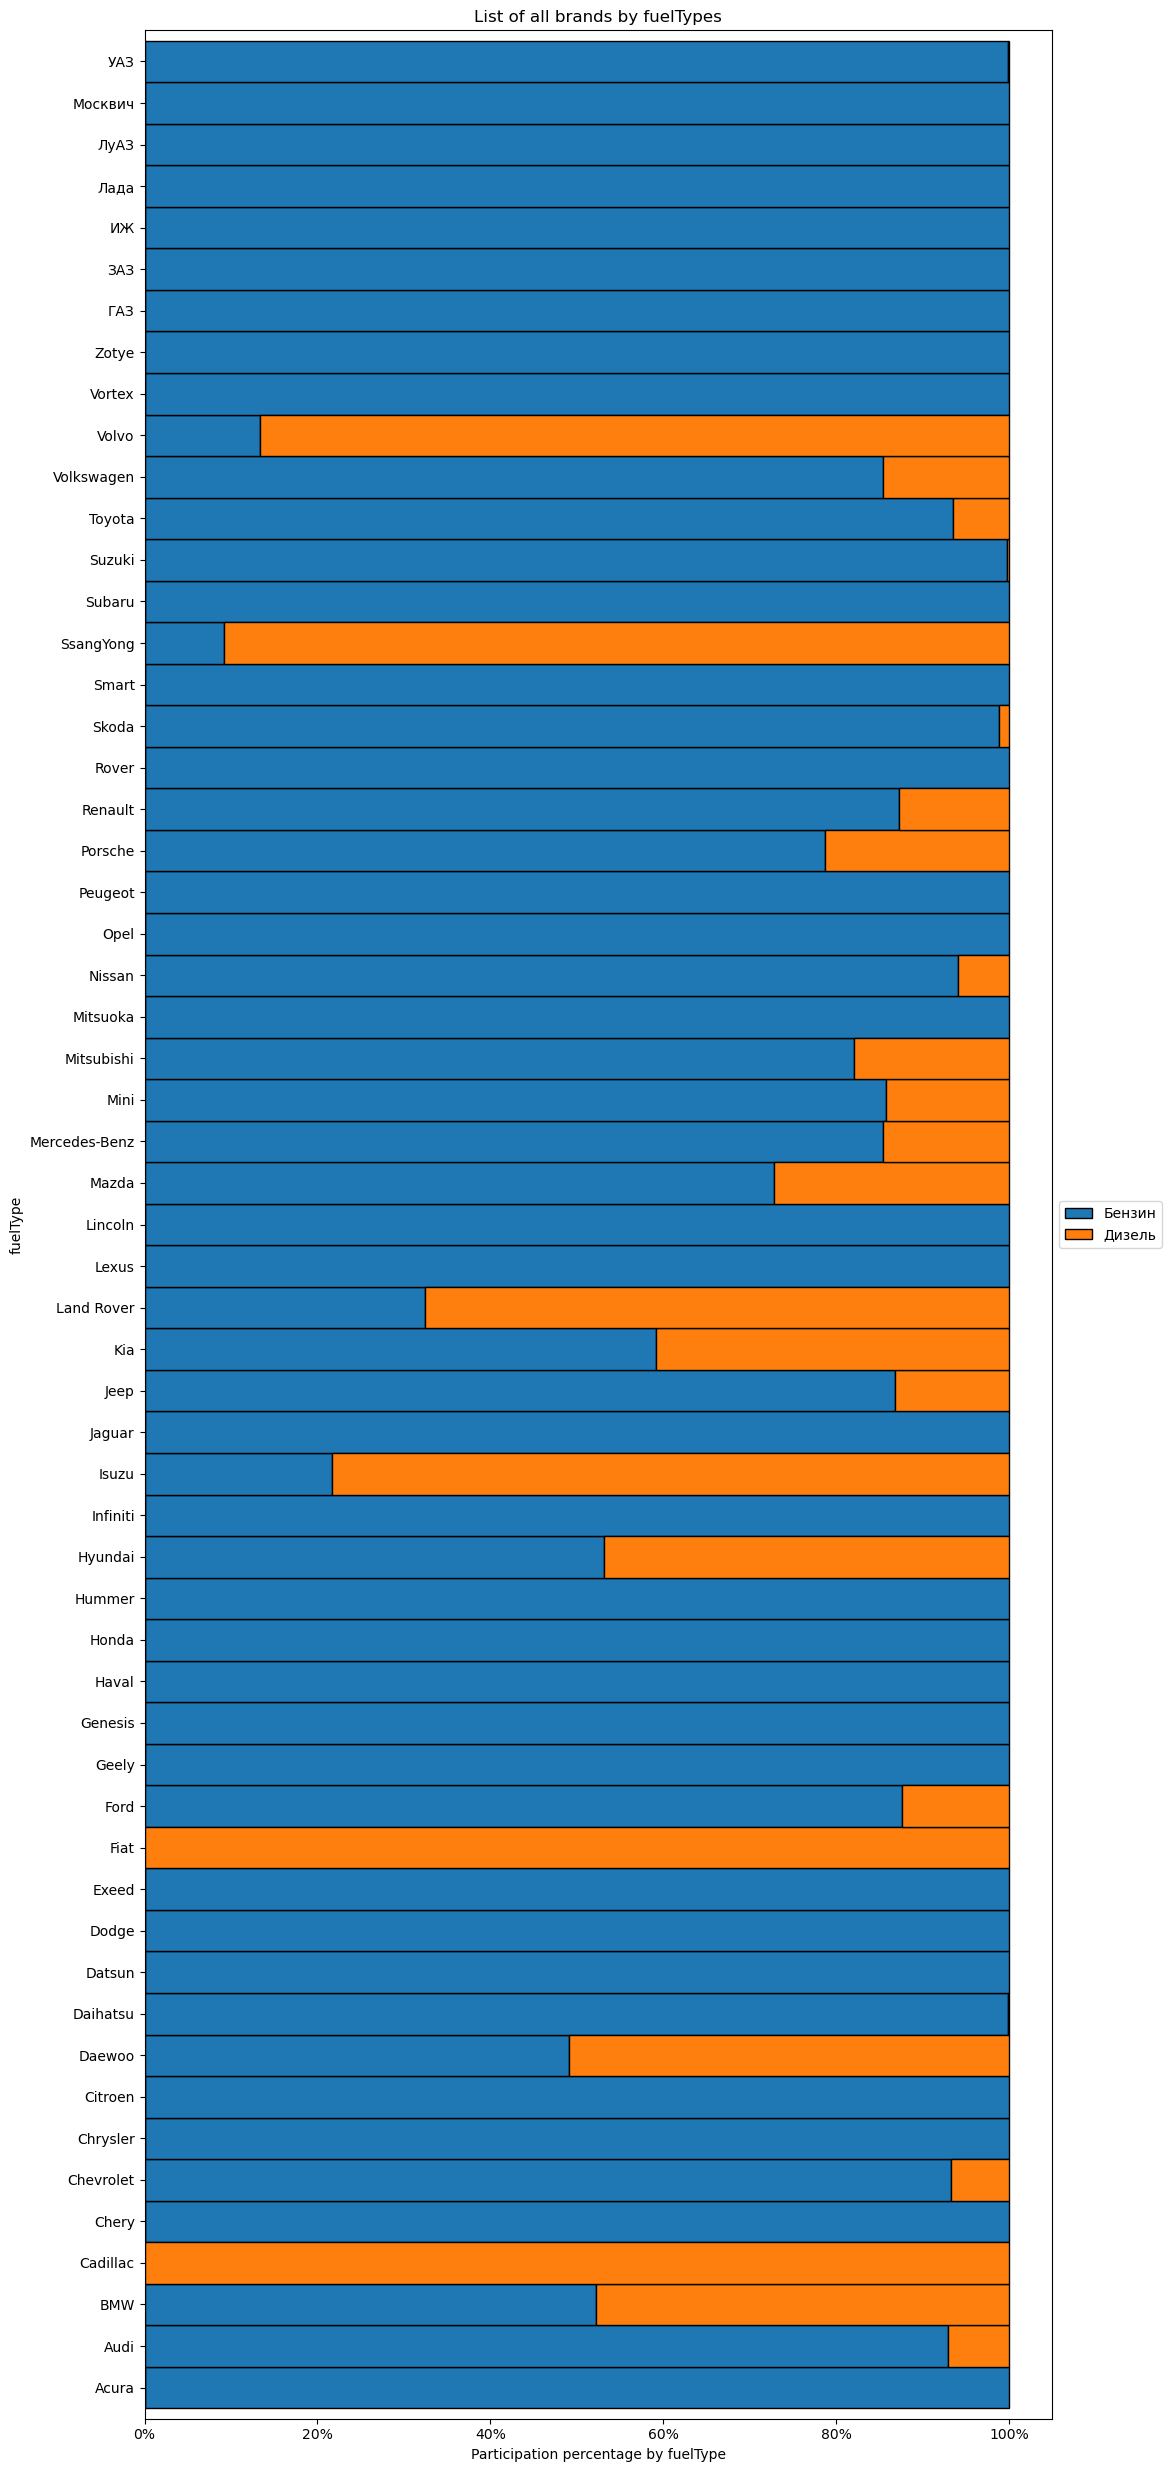

In [10]:
brands_by_fuelType_df = df.groupBy(df.brand, df.fuelType).count().toPandas()

fuelTypes = brands_by_fuelType_df['fuelType'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = brands_by_fuelType_df.groupby(['brand', 'fuelType'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='List of all brands by fuelTypes')
ylabel = plt.ylabel('fuelType');
xlabel = plt.xlabel('Participation percentage by fuelType');
legend = plt.legend(
    sorted(fuelTypes), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

# Находим 10 популярных брендов с бензиновыми и дизельными двигателями

In [11]:
brands_by_fuelType_df = df.groupBy(df.brand, df.fuelType).count().toPandas().pivot_table(
    index="brand", columns="fuelType", values='count', fill_value=0) \
    .reset_index() \
    .rename_axis(None, axis=1) \
    
brands_by_fuelType_df['всего'] = 0
for fuelType in fuelTypes:
    brands_by_fuelType_df['всего'] += brands_by_fuelType_df[fuelType]
    
brands_by_fuelType_df['процент'] = brands_by_fuelType_df['всего'] / np.sum(brands_by_fuelType_df['всего']) * 100

for fuelType in fuelTypes:
    brands_by_fuelType_df['процент ' + fuelType ] = \
        (brands_by_fuelType_df[fuelType] / brands_by_fuelType_df['всего']) * 100

top_brands_by_fuelType_df = brands_by_fuelType_df.sort_values(
    by='процент', ascending=False
).head(10)

others = {'brand' : 'others'}
for column in [*['всего', 'процент'], *fuelTypes,]:
    value = np.sum(brands_by_fuelType_df[column]) - np.sum(top_brands_by_fuelType_df[column])
    others.update({column: value})

for fuelType in fuelTypes:
    value = (others[fuelType] / others['всего']) * 100
    others.update({'процент ' + fuelType : value})
    
top_brands_by_fuelType_df = pd.concat([top_brands_by_fuelType_df,pd.DataFrame.from_dict([others])]) \
                                .reset_index(drop=True)
top_brands_by_fuelType_df

,brand,Бензин,Дизель,всего,процент,процент Бензин,процент Дизель
0,Toyota,399988,27399,427387,49.198401,93.589183,6.410817
1,Honda,134621,0,134621,15.496817,100.000000,0.000000
2,Nissan,96944,6028,102972,11.853561,94.145981,5.854019
3,Mitsubishi,27671,6035,33706,3.880046,82.095176,17.904824
4,Subaru,32811,0,32811,3.777019,100.000000,0.000000
5,Suzuki,29675,50,29725,3.421776,99.831791,0.168209
6,Lexus,23976,0,23976,2.759983,100.000000,0.000000
7,Mazda,17435,6506,23941,2.755954,72.824861,27.175139
8,Daihatsu,14780,16,14796,1.703233,99.891863,0.108137
9,Mercedes-Benz,6368,1083,7451,0.857717,85.465038,14.534962


# Найдём 10 брендов, которые используют бензин

In [12]:
top_brands_by_gasoline_df = brands_by_fuelType_df.sort_values(
    by='процент Дизель', ascending=False
).head(10).reset_index(drop=True)

top_brands_by_gasoline_df

,brand,Бензин,Дизель,всего,процент,процент Бензин,процент Дизель
0,Cadillac,0,16,16,0.001842,0.000000,100.000000
1,Fiat,0,18,18,0.002072,0.000000,100.000000
2,SsangYong,119,1172,1291,0.148613,9.217661,90.782339
3,Volvo,20,130,150,0.017267,13.333333,86.666667
4,Isuzu,379,1367,1746,0.200990,21.706758,78.293242
5,Land Rover,292,607,899,0.103488,32.480534,67.519466
6,Daewoo,88,91,179,0.020605,49.162011,50.837989
7,BMW,3076,2819,5895,0.678599,52.179813,47.820187
8,Hyundai,3028,2662,5690,0.655001,53.216169,46.783831
9,Kia,1858,1283,3141,0.361574,59.153136,40.846864


# Находим 10 популярных брендов с разными коробками передач

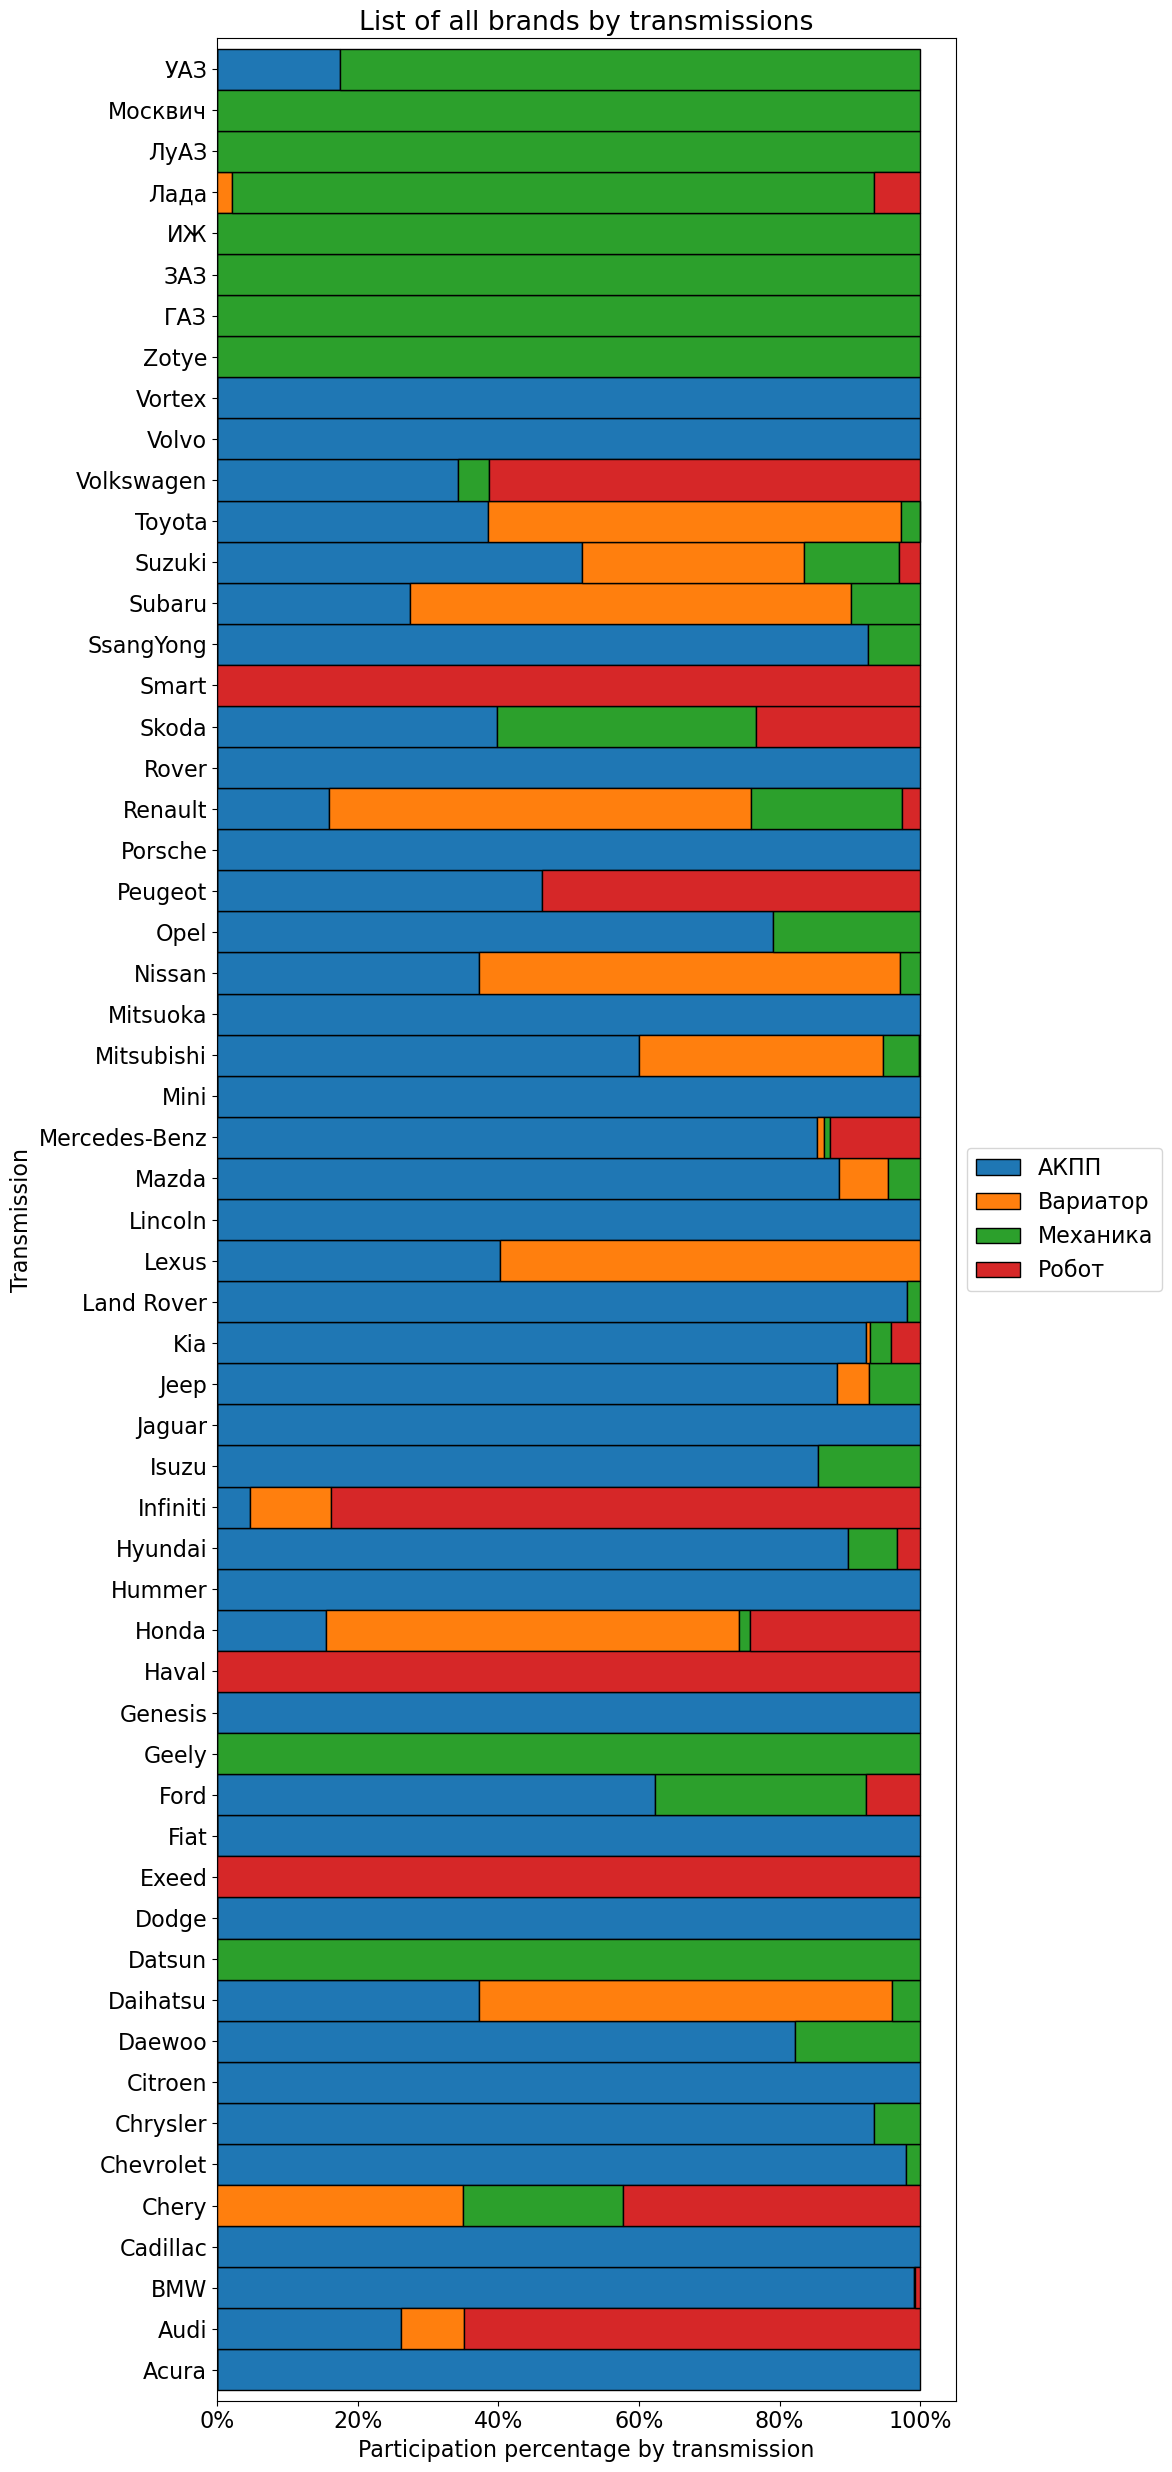

In [13]:
brands_by_transmission_df = df.groupBy(df.brand, df.transmission).count().toPandas()

transmissions = brands_by_transmission_df['transmission'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = brands_by_transmission_df.groupby(['brand', 'transmission'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='List of all brands by transmissions')
ylabel = plt.ylabel('Transmission');
xlabel = plt.xlabel('Participation percentage by transmission');
legend = plt.legend(
    sorted(transmissions), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

Процентное соотношение использование КПП брендами

In [14]:
brands_by_transmission_df = df.groupBy(df.brand, df.transmission).count().toPandas().pivot_table(
    index="brand", columns="transmission", values='count', fill_value=0) \
    .reset_index() \
    .rename_axis(None, axis=1) \
    
brands_by_transmission_df['всего'] = 0
for transmission in transmissions:
    brands_by_transmission_df['всего'] += brands_by_transmission_df[transmission]
    
brands_by_transmission_df['процент'] = brands_by_transmission_df['всего'] / np.sum(brands_by_transmission_df['всего']) * 100

for transmission in transmissions:
    brands_by_transmission_df['процент ' + transmission] = \
        (brands_by_transmission_df[transmission] / brands_by_transmission_df['всего']) * 100

top_brands_by_transmission_df = brands_by_transmission_df.sort_values(
    by='процент', ascending=False
).head(10)

others = {'brand' : 'others'}
for column in [*['всего', 'процент'], *transmissions,]:
    value = np.sum(brands_by_transmission_df[column]) - np.sum(top_brands_by_transmission_df[column])
    others.update({column: value})

for transmission in transmissions:
    value = (others[transmission] / others['всего']) * 100
    others.update({'процент ' + transmission: value})
    
top_brands_by_transmission_df = pd.concat([top_brands_by_transmission_df,pd.DataFrame.from_dict([others])]) \
                                .reset_index(drop=True)

top_brands_by_transmission_df

,brand,АКПП,Вариатор,Механика,Робот,всего,процент,процент АКПП,процент Механика,процент Робот,процент Вариатор
0,Toyota,164396,251500,11301,190,427387,49.198401,38.465372,2.644208,0.044456,58.845964
1,Honda,20933,78978,2079,32631,134621,15.496817,15.549580,1.544336,24.239160,58.666924
2,Nissan,38345,61651,2976,0,102972,11.853561,37.238278,2.890106,0.000000,59.871616
3,Mitsubishi,20200,11728,1707,71,33706,3.880046,59.929983,5.064380,0.210645,34.794992
4,Subaru,8984,20569,3258,0,32811,3.777019,27.381061,9.929597,0.000000,62.689342
5,Suzuki,15414,9388,4014,909,29725,3.421776,51.855341,13.503785,3.058032,31.582843
6,Lexus,9652,14324,0,0,23976,2.759983,40.256924,0.000000,0.000000,59.743076
7,Mazda,21176,1670,1095,0,23941,2.755954,88.450775,4.573744,0.000000,6.975481
8,Daihatsu,5504,8698,594,0,14796,1.703233,37.199243,4.014599,0.000000,58.786158
9,Mercedes-Benz,6357,77,56,961,7451,0.857717,85.317407,0.751577,12.897598,1.033418


# Распределение цен на автомобили

array([[<AxesSubplot: title={'center': 'price'}>]], dtype=object)

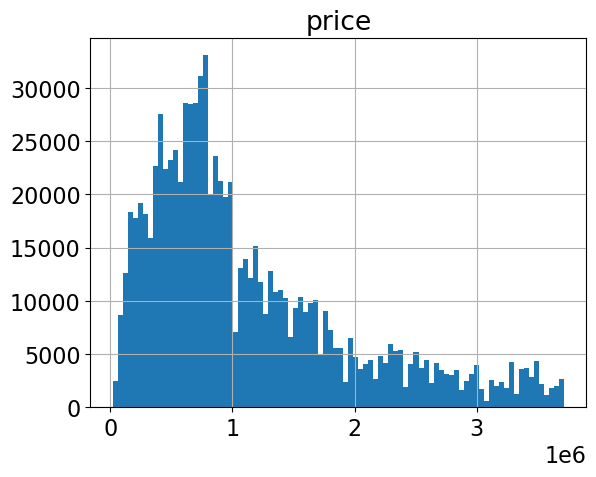

In [36]:
df.select(df.price).toPandas().hist(column='price',bins=90)

# Отобразим, какие среднии цены были на протяжении 20-ти лет

<AxesSubplot: xlabel='year'>

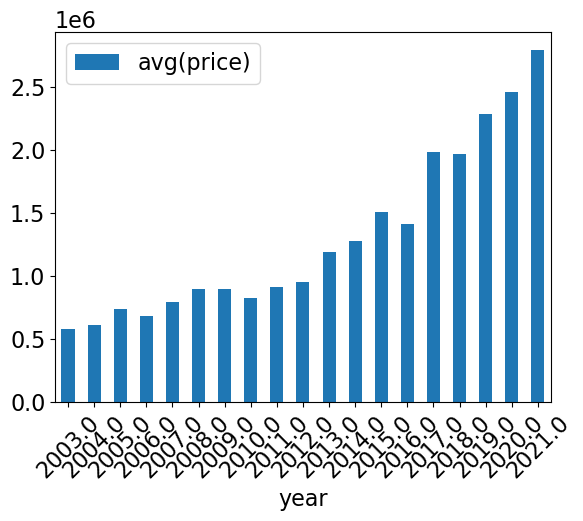

In [16]:
years = [2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003]

df.select(df.year, df.price) \
    .filter(df.year.isin(years)) \
    .groupBy(df.year) \
    .avg('price') \
    .toPandas() \
    .sort_values(by='year') \
    .plot.bar(column="avg(price)", x='year', rot=45)

# Средняя цена каждого бренда

<AxesSubplot: ylabel='brand'>

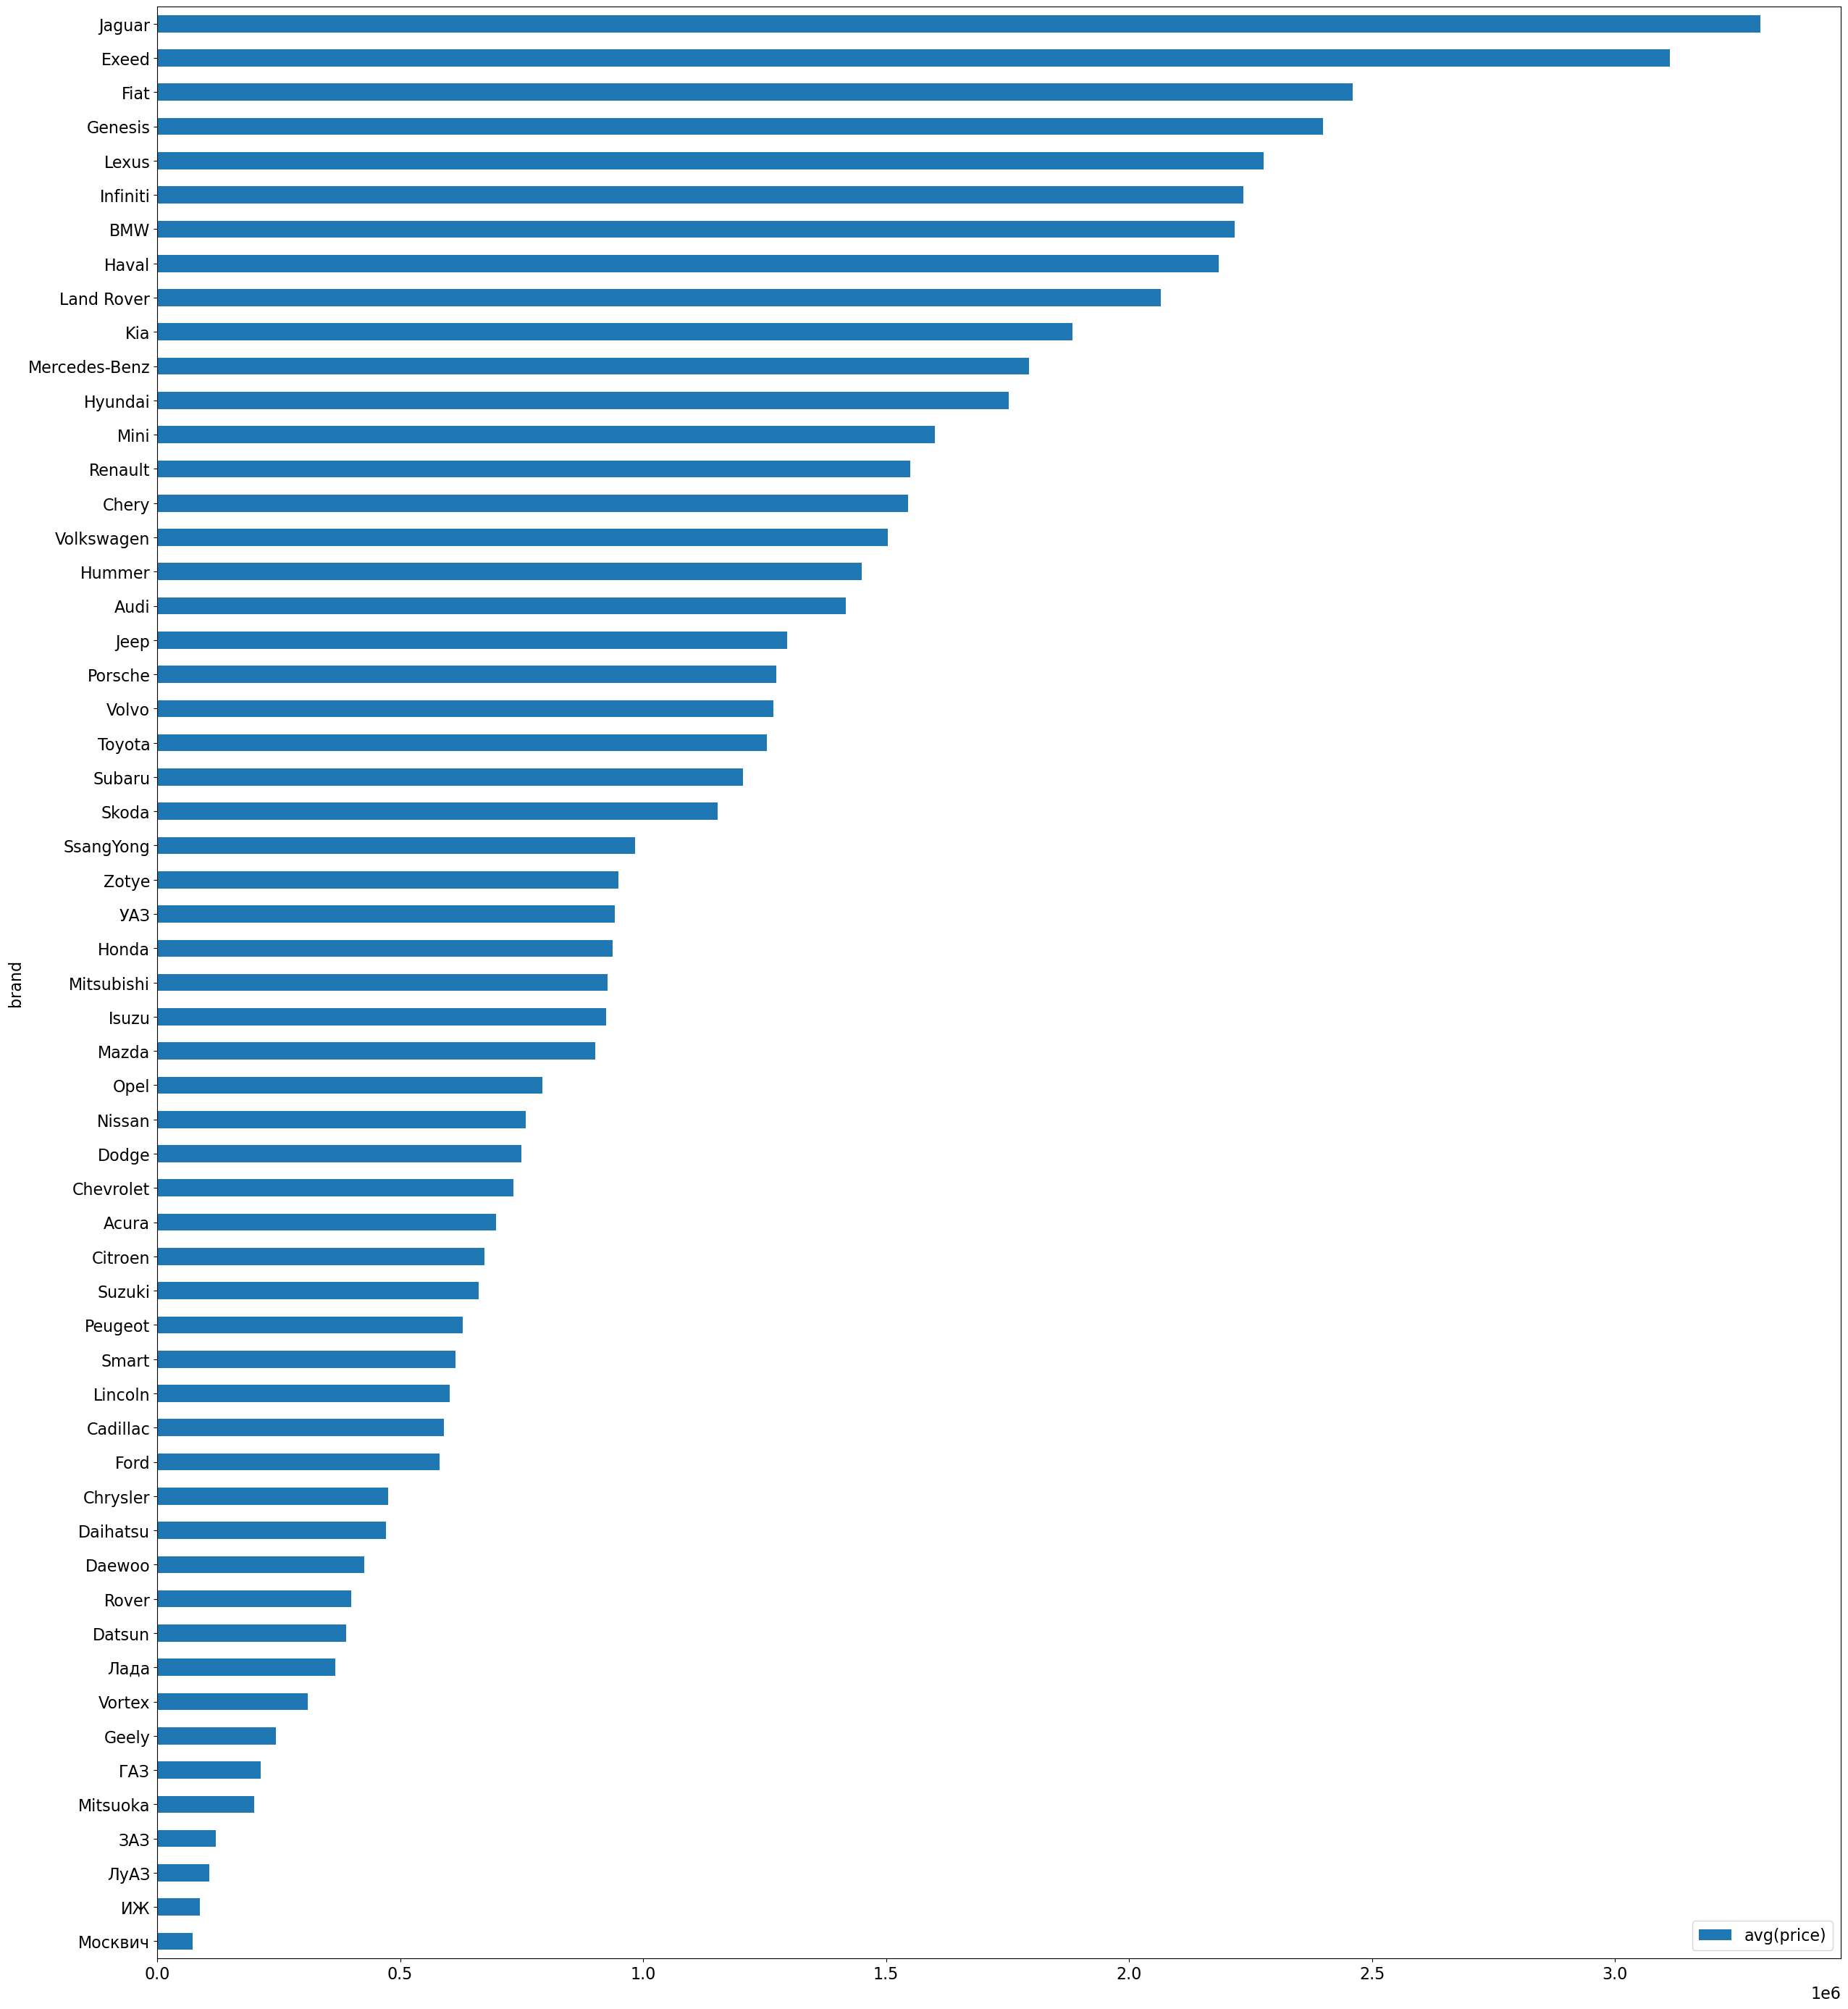

In [17]:
df.select(df.brand, df.price) \
    .groupBy(df.brand) \
    .avg('price') \
    .toPandas() \
    .sort_values(by='avg(price)') \
    .plot.barh(column="avg(price)", x='brand', figsize=(30,35))

# Средняя мощность двигателя у 10 брендов

In [18]:
highest_cars_brands_power_mean = []
highest_cars_brands_power_stddev = []
highest_cars_brands_power_min = []
highest_cars_brands_power_max = []

for brand in highest_cars_brands_df['brand']:
    if brand != 'others': 
        describe_values = df.select(df.power).filter(df.brand == brand).describe().toPandas()
    else:
        brands = highest_cars_brands_df['brand'].tolist()
        describe_values = df.select(df.power).filter(col('brand').isin(brands) == False).describe().toPandas()
    highest_cars_brands_power_mean.append(float(describe_values.loc[1]['power']))
    highest_cars_brands_power_stddev.append(float(describe_values.loc[2]['power']))
    highest_cars_brands_power_min.append(float(describe_values.loc[3]['power']))
    highest_cars_brands_power_max.append(float(describe_values.loc[4]['power']))

highest_cars_brands_df['mean power'] = highest_cars_brands_power_mean
highest_cars_brands_df['stddev power'] = highest_cars_brands_power_stddev
highest_cars_brands_df['min power'] = highest_cars_brands_power_min
highest_cars_brands_df['max power'] = highest_cars_brands_power_max
    
highest_cars_brands_df

,brand,count,percentage,mean power,stddev power,min power,max power
0,Toyota,427387,28.243920,132.860749,42.997205,49.0,258.0
1,Honda,134621,8.896445,119.528736,28.760356,45.0,257.0
2,Nissan,102972,6.804917,123.900983,39.967078,48.0,250.0
3,Mitsubishi,33706,2.227465,135.330001,43.190618,40.0,250.0
4,Subaru,32811,2.168319,156.467008,38.150329,46.0,250.0
5,Suzuki,29725,1.964380,90.183448,33.369758,38.0,185.0
6,Lexus,23976,1.584457,184.747080,54.356059,99.0,249.0
7,Mazda,23941,1.582144,128.232112,40.444276,49.0,250.0
8,Daihatsu,14796,0.977795,66.063193,19.116455,45.0,140.0
9,Mercedes-Benz,7451,0.492400,189.334720,33.121544,114.0,258.0


# Диаграмма "ящик с усами" по всем произовителям с мощностью двигателя

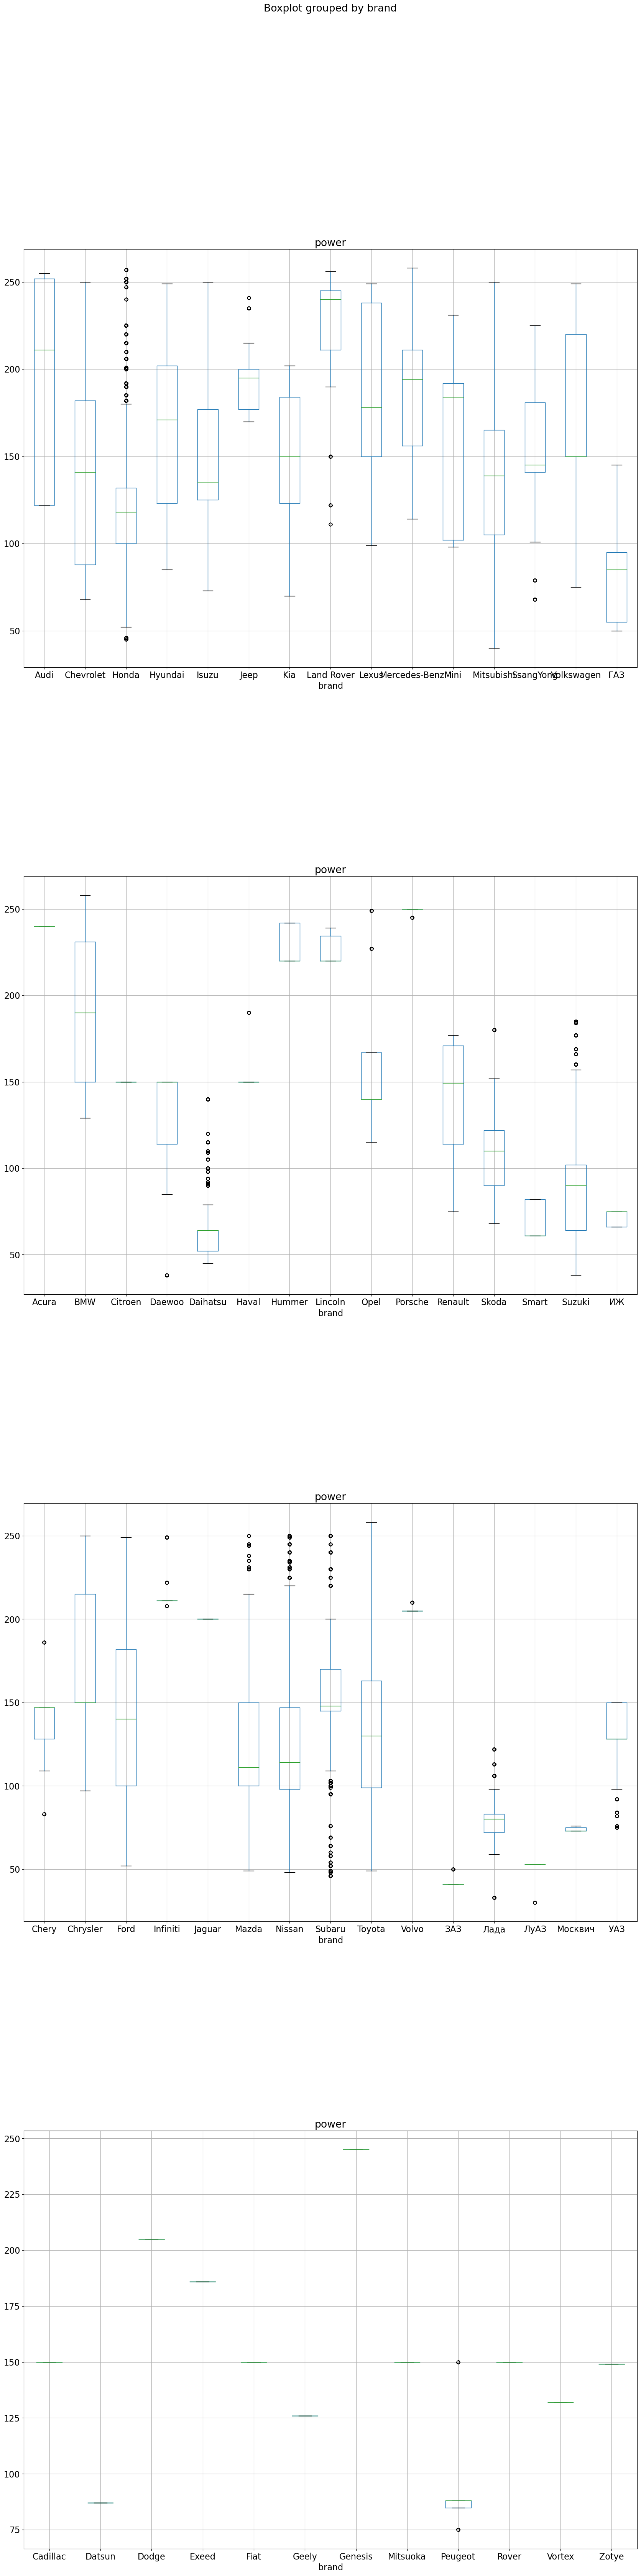

In [19]:
all_brands = df.select(df.brand).distinct().toPandas()
boxplot_cols = 15
boxplot_rows = math.ceil(all_brands.count()/boxplot_cols)

fig, axes = plt.subplots(boxplot_rows, figsize=(20, 80))

for row in range(0,boxplot_rows):
    current_brands = all_brands.iloc[row*boxplot_cols:row*boxplot_cols+boxplot_cols]['brand'].values.tolist()
    power_df = df.select(df.brand, df.power).filter(col('brand').isin(current_brands)).toPandas()
    power_df['power'] = power_df['power'].astype('float')
    power_df.boxplot(column='power', by='brand', ax=axes[row])
    
plt.subplots_adjust(hspace=0.5)
plt.show();

# Узнаем, какие бренды продавали больше всех автомобилей и отобразим топ 10 производителей с моделью

In [20]:
all_brands = df.select(df.brand) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

most_popular_name = []

for brand in all_brands:
    most_popular_names = df.select(df.name) \
        .filter(df.brand==brand) \
        .groupBy(df.name) \
        .count() \
        .orderBy('count', ascending=False) \
        .head(1)[0]
    
    most_popular_name.append(
        {
            'brand': brand,
            'name': most_popular_names.name,
            'count': most_popular_names['count']
        }
    )
    
top_most_popular_name_df = pd.DataFrame(most_popular_name) \
    .sort_values(by='count', ascending=False) \
    .head(10) \
    .reset_index(drop=True)
top_most_popular_name_df

,brand,name,count
0,Toyota,Prius,39004
1,Honda,Fit,26399
2,Nissan,Note,21088
3,Subaru,Forester,15745
4,Mazda,Demio,6544
5,Suzuki,Jimny,6035
6,Mitsubishi,Outlander,5894
7,Lexus,CT200h,4561
8,Daihatsu,Move,3077
9,Mercedes-Benz,C-Class,2876


# Статистика по ценам для каждого города

In [21]:
locations_prices_statistic_df = []
all_locations = df.select(df.location) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

for location in all_locations:
    stat_dict = {'location': location}
    location_prices_df = df.select(df.price).filter(df.location==location)
    stats = location_prices_df.select(
        percentile_approx(df.price,[0.25,0.5,0.75,0.95], 1000000).alias("percentiles"),
        min('price').alias('min'),
        max('price').alias('max'),
        mean('price').alias('mean'),
        stddev('price').alias('stddev'),
    ).collect()[0]
    stat_dict['25th percentile'] = stats['percentiles'][0] 
    stat_dict['50th percentile'] = stats['percentiles'][1]
    stat_dict['75th percentile'] = stats['percentiles'][2]
    stat_dict['95th percentile'] = stats['percentiles'][3]
    
    stat_dict['min'] = stats['min']
    stat_dict['max'] = stats['max']
    stat_dict['mean'] = stats['mean']
    stat_dict['stddev'] = stats['stddev']
    
    locations_prices_statistic_df.append(stat_dict)
    
locations_prices_statistic_df = pd.DataFrame(locations_prices_statistic_df)
locations_prices_statistic_df

,location,25th percentile,50th percentile,75th percentile,95th percentile,min,max,mean,stddev
0,Уссурийск,520000,800000,1315000,2720000,25000,3710000,1.033500e+06,763492.986825
1,Шкотово,225000,265000,410000,1700000,70000,3600000,4.818384e+05,717119.924401
2,Посьет,250000,550000,725000,1099000,230000,1099000,5.715608e+05,285488.821191
3,Камень-Рыболов,380000,700000,1130000,1550000,125000,3450000,7.761054e+05,540308.235118
4,Галёнки,180000,395000,460000,1050000,160000,1050000,3.709194e+05,217721.844488
...,...,...,...,...,...,...,...,...,...
63,Чкаловское,90000,90000,90000,90000,90000,90000,9.000000e+04,0.000000
64,Приморский,85000,85000,100000,100000,85000,100000,9.029412e+04,7388.882746
65,Николаевка,310000,420000,1175000,1200000,90000,1200000,7.263529e+05,441387.415022
66,Новосысоевка,150000,220000,220000,220000,150000,220000,1.940741e+05,34447.201434


# Гистограммы (для статистики квантилей) и линейные диаграммы (для мин/макс/среднее/стандартное отклонение)

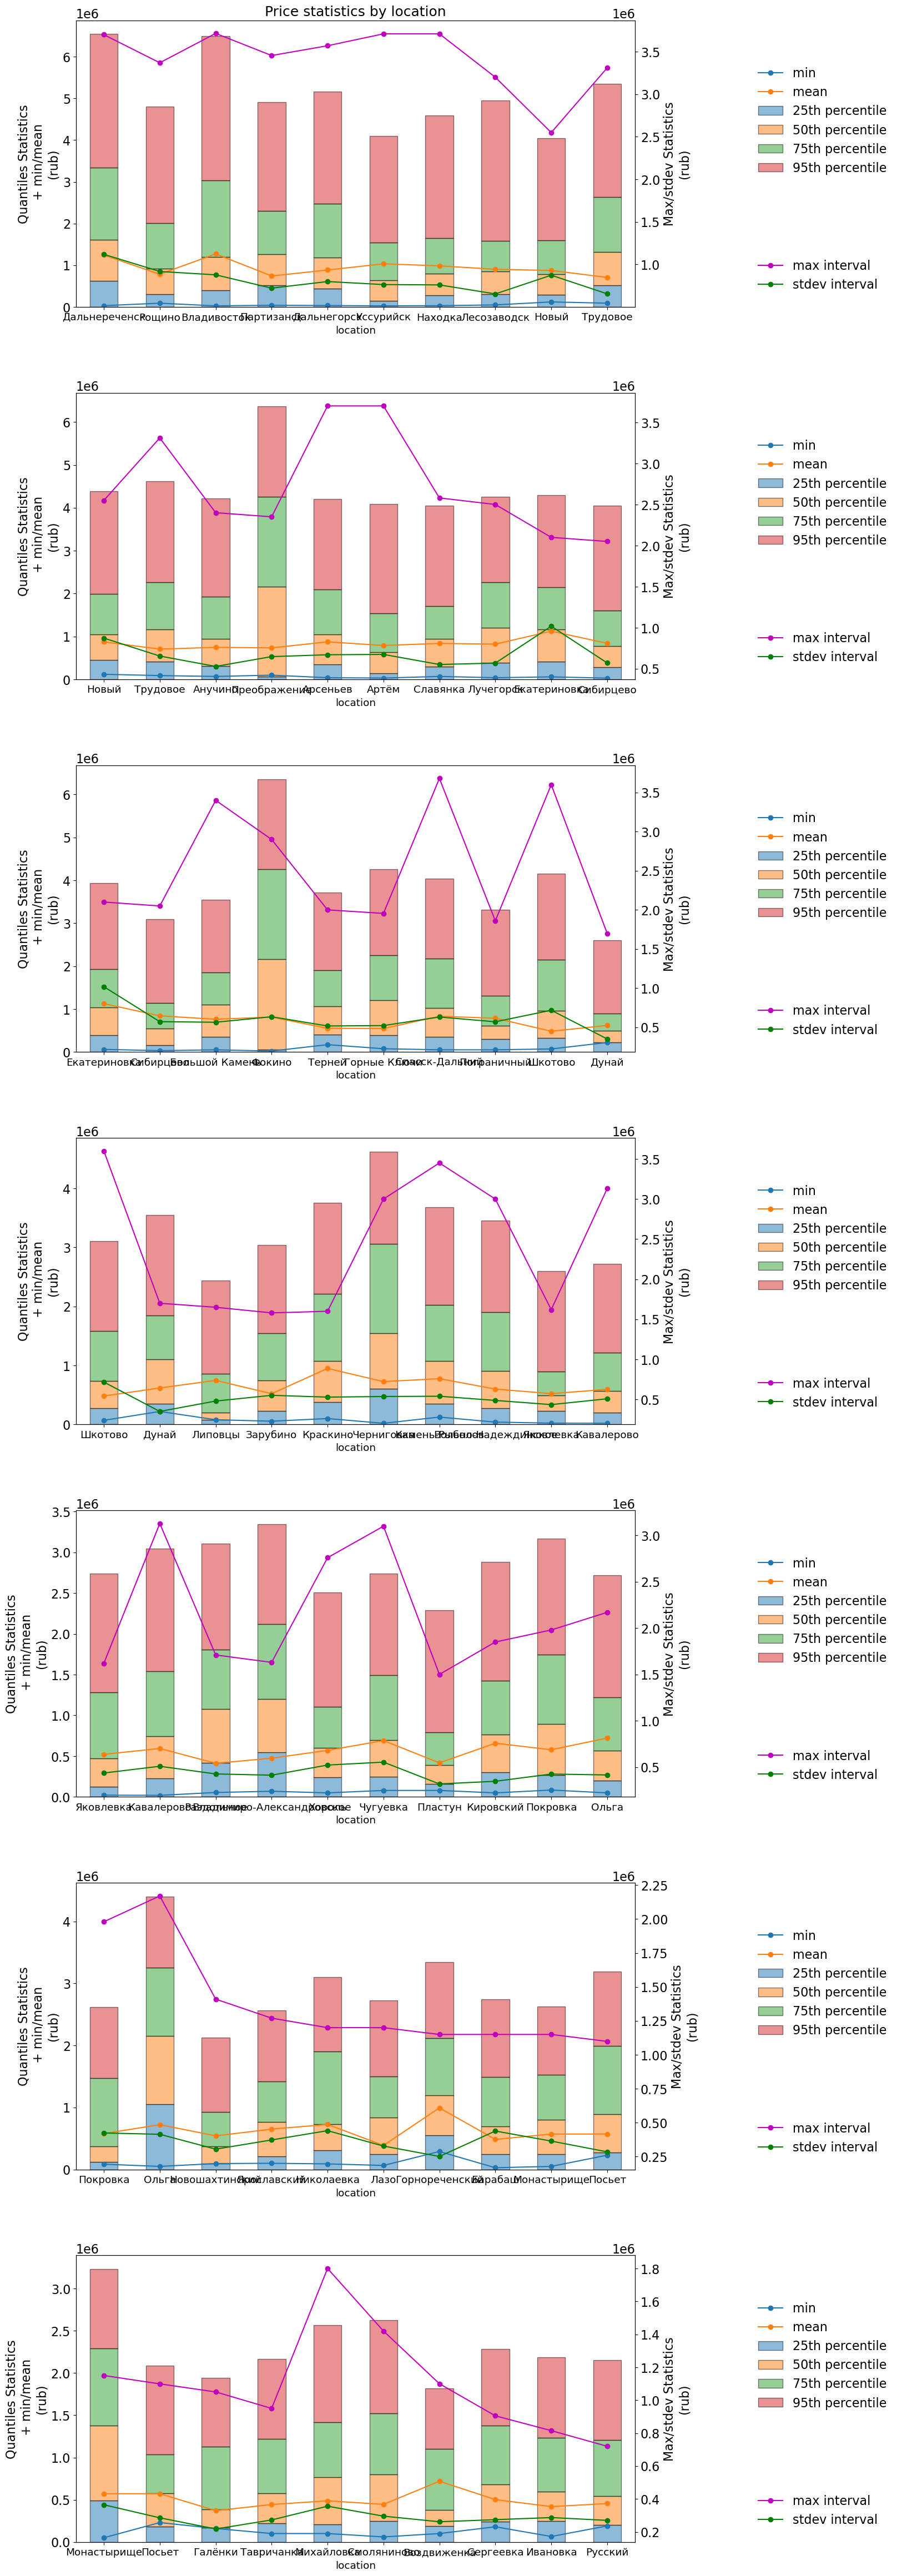

In [28]:
bar_columns = ['25th percentile', '50th percentile'
               , '75th percentile', '95th percentile']
line_columns1 = ['min', 'mean'] 
line_columns2 = ['max', 'stddev'] 
locations_prices_statistic_df = locations_prices_statistic_df.sort_values(
    by='95th percentile', ascending=False
)
figsize=(13, 59)
nrows = math.ceil(len(all_locations)/10)
fig, axs = plt.subplots(nrows=nrows, figsize=figsize)

d = axs[0].set_title('Price statistics by location', fontsize=18)
for i in range (nrows):
    locations_prices_statistic_sub_df = locations_prices_statistic_df.iloc[i*8:i*8+10,]
    plot1 = locations_prices_statistic_sub_df[['location'] + bar_columns] \
        .groupby(['location']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i], 
    )
    plot2 = locations_prices_statistic_sub_df[['location'] + line_columns1].plot(x='location', ax=axs[i], marker='o')
    ax2 = axs[i].twinx()
    plot3 = locations_prices_statistic_sub_df[['location'] + line_columns2].plot( x='location', ax=ax2, marker='o', color=['m', 'g'])
    a = axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.65), frameon=False)
    a = ax2.legend(  labels=['max interval', 'stdev interval']
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(locations_prices_statistic_sub_df['location'],rotation = 'horizontal', fontsize='small')
    c = axs[i].set_xlabel('location', fontsize='small');
    d = axs[i].set_ylabel('Quantiles Statistics\n + min/mean\n(rub)', fontsize=16);
    e = ax2.set_ylabel('Max/stdev Statistics\n(rub)', fontsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.3)
plt.show();

<AxesSubplot: ylabel='процент'>

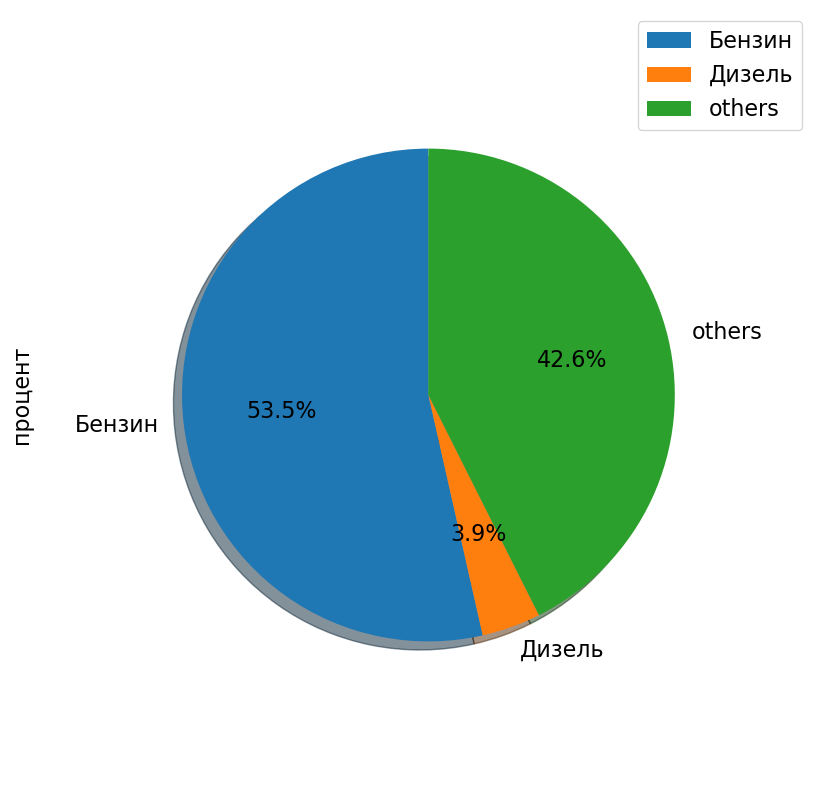

In [30]:
highest_fuelTypes_df = df.select(df.fuelType, df.mileage) \
    .groupBy(df.fuelType) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5) \
    .toPandas()

highest_fuelTypes_df['процент'] = highest_fuelTypes_df['count'] \
    / total_cars_count * 100

others = {
    'fuelType': 'others', 
    'count': total_cars_count - np.sum(highest_fuelTypes_df['count']), 
    'процент': 100 - np.sum(highest_fuelTypes_df['процент'])
}

highest_fuelTypes_df = pd.concat([highest_fuelTypes_df,pd.DataFrame.from_dict([others])])

highest_fuelTypes_df.plot.pie(
    y='процент',
    labels=highest_fuelTypes_df['fuelType'], 
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=90, 
    radius=0.8,
    figsize=(10, 10)
)